In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import argparse
import numpy as np
import matplotlib.pyplot as plt

# import datetime
# import scipy.io as sio

from func_model import My_RNN_model
from func_utils import train_model, validate_model, test_model

In [3]:
# Check GPU or CPU for training.
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda:2


In [4]:
'设置随机种子'
# seed = 116
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(seed)

'Learning Parameters'
# initial_run = 0    # 0: Continue training; 1: Starts from the scratch
# max_epochs = 10000    # Num of epochs
# learning_rate = 0.0001  # Learning rate

max_epochs = 40         # Num of epochs
learning_rate = 0.0001  # Learning rate

'System Information'
M_antanna_num = 8      # Number of BS's antennas, 对应论文中的 Mr 基站的天线个数
N_grid_point_num = 128  # Number of posterior intervals inputed to DNN
# N_grid_point_num = 16  # Number of posterior intervals inputed to DNN
S = np.log2(N_grid_point_num)   # 波束模式的分级 数
tau = int(2*S)  # Pilot length

'Channel Information'
# phi_min = -60*(np.pi/180)   # Lower-bound of AoAs
phi_min = 0*(np.pi/180)   # Lower-bound of AoAs
phi_max = 60*(np.pi/180)    # Upper-bound of AoAs
num_SNR = 8         # Number of considered SNRs
low_SNR_idx = 0     # Index of Lowest SNR for training
high_SNR_idx = 8    # Index of highest SNR for training + 1
idx_SNR_val = 7     # Index of SNR for validation (saving parameters)

snrdBvec = np.linspace(start=-10, stop=25, num=num_SNR)  # Set of SNRs
Pvec = 10 ** (snrdBvec / 10)        # Set of considered TX powers

'Learning Parameters'
batch_per_epoch = 10    # Number of mini batches per epoch

batch_size_order = 8    # Mini_batch_size = batch_size_order*delta_inv
batch_size_train = batch_size_order * N_grid_point_num
val_size_order = 782  # Validation_set_size = val_size_order*delta_inv
batch_size_val = val_size_order * N_grid_point_num
scale_factor = 1  # Scaling the number of tests
test_size_order = 782  # Test_set_size = test_size_order*delta_inv*scale_factor
batch_size_test = test_size_order * N_grid_point_num

hidden_size = 512

In [5]:
argparser = argparse.ArgumentParser(description = 'Active Learning of Sensing Vector')
argparser.add_argument('--max_epochs', type =int, help='Num of Epoches', default = max_epochs)
argparser.add_argument('--learning_rate', type = float, help='Learning Rate', default = learning_rate)
argparser.add_argument('--M_antenna_num', type = int, help='Number of Antennas', default = M_antanna_num)
argparser.add_argument('--N_grid_point_num', type = int, help='Number of Angle Intervals', default = N_grid_point_num)
argparser.add_argument('--S', type = int, help='Number of Tiers (log2(N_grid_point_num))', default = S)
argparser.add_argument('--tau', type = int, help='Number of LSTM cells (2*S)', default = tau)
argparser.add_argument('--phi_min', type = float, help='Lower-limit of AoAs', default = phi_min)
argparser.add_argument('--phi_max', type = float, help='Upper-limit of AoAs', default = phi_max)
argparser.add_argument('--num_SNR', type = int, help='Number of Considered SNR Levels', default = num_SNR)
argparser.add_argument('--low_SNR_idx', type = int, help='Index of Lowest SNR for training', default = low_SNR_idx)
argparser.add_argument('--high_SNR_idx', type = int, help='Index of highest SNR for training + 1', default = high_SNR_idx)
argparser.add_argument('--idx_SNR_val', type = float, help='Index of SNR for validation', default = idx_SNR_val)
argparser.add_argument('--snrdBvec', type = float, help='Set of SNRs', default = snrdBvec)
argparser.add_argument('--Pvec', type = float, help='powers', default = Pvec)
argparser.add_argument('--batch_per_epoch', type = int, help='Number of mini batches per epoch', default = batch_per_epoch)
argparser.add_argument('--batch_size_order', type = int, help='Mini_batch_size = batch_size_order*delta_inv', default = batch_size_order)
argparser.add_argument('--val_size_order', type = int, help='Validation_set_size = val_size_order*delta_inv', default = val_size_order)
argparser.add_argument('--test_size_order', type = int, help='Test_set_size = test_size_order*delta_inv*scale_factor', default = test_size_order)
argparser.add_argument('--batch_size_train', type = int, help='Number of mini batches per epoch', default = batch_size_train)
argparser.add_argument('--batch_size_val', type = int, help='Number of mini batches per epoch', default = batch_size_val)
argparser.add_argument('--batch_size_test', type = int, help='Number of mini batches per epoch', default = batch_size_test)

argparser.add_argument('--hidden_size', type = int, help='Hidden Node Size', default = hidden_size)

args, _ = argparser.parse_known_args()
print(args)

Namespace(max_epochs=40, learning_rate=0.0001, M_antenna_num=8, N_grid_point_num=128, S=7.0, tau=14, phi_min=0.0, phi_max=1.0471975511965976, num_SNR=8, low_SNR_idx=0, high_SNR_idx=8, idx_SNR_val=7, snrdBvec=array([-10.,  -5.,   0.,   5.,  10.,  15.,  20.,  25.]), Pvec=array([1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02]), batch_per_epoch=10, batch_size_order=8, val_size_order=782, test_size_order=782, batch_size_train=1024, batch_size_val=100096, batch_size_test=100096, hidden_size=512)


In [8]:
model = My_RNN_model(args).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(params=model.parameters(), lr=args.learning_rate)

resume = 1
PATH = './checkpoints/' + model.name() + '_weights.pth'
if resume == 1:
    model.load_state_dict( torch.load(PATH, map_location=device) )

RuntimeError: CUDA error: invalid device ordinal
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
best_val_loss = validate_model(model=model, criterion=criterion, args=args)
# start training
for epoch in range(max_epochs):

    train_loss = train_model(model=model, criterion=criterion, optimizer=optimizer, args=args)
    validate_loss = validate_model(model=model, criterion=criterion, args=args)

    print('\n'f"Epoch {epoch}-----------------------------------------------")
    print('epoch:', epoch, ' train_loss:%2.9f' % train_loss, ' validate_loss:%2.9f' % validate_loss, ' best_val_loss:%2.9f' % best_val_loss)

    if validate_loss < best_val_loss:
        best_val_loss = validate_loss        
        torch.save(model.state_dict(), PATH)


Epoch 0-----------------------------------------------
epoch: 0  train_loss:0.005987551  validate_loss:0.001992064  best_val_loss:0.002081338

Epoch 1-----------------------------------------------
epoch: 1  train_loss:0.006437812  validate_loss:0.002174413  best_val_loss:0.001992064

Epoch 2-----------------------------------------------
epoch: 2  train_loss:0.005933725  validate_loss:0.001921518  best_val_loss:0.001992064

Epoch 3-----------------------------------------------
epoch: 3  train_loss:0.005263560  validate_loss:0.001876930  best_val_loss:0.001921518

Epoch 4-----------------------------------------------
epoch: 4  train_loss:0.010721884  validate_loss:0.001853041  best_val_loss:0.001876930

Epoch 5-----------------------------------------------
epoch: 5  train_loss:0.012075251  validate_loss:0.001943049  best_val_loss:0.001853041

Epoch 6-----------------------------------------------
epoch: 6  train_loss:0.003634983  validate_loss:0.002033512  best_val_loss:0.001853041

In [9]:
# start testing
snrdBvec, performance = test_model(model=model, criterion=criterion, args=args)
print('snrdBvec:', snrdBvec)
print('performance:', performance)
print("Done!-----------------------------------------------------------------\n")

np.save('snrdBvec.npy', snrdBvec)
np.save('performance_fixed.npy', performance)


# Create a figure and axis
fig, ax = plt.subplots()
# Plot data
ax.semilogy(snrdBvec, performance, label='MSE vs SNR', marker='o')
# Set labels and title
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('MSE')
ax.set_title('MSE vs SNR')
# Display legend
ax.legend()
# Show the plot
plt.show()


NameError: name 'model' is not defined

[-10.  -5.   0.   5.  10.  15.  20.  25.]
[0.02799631 0.01219727 0.00417313 0.00158536 0.00089289 0.00065337
 0.00058319 0.00057039]


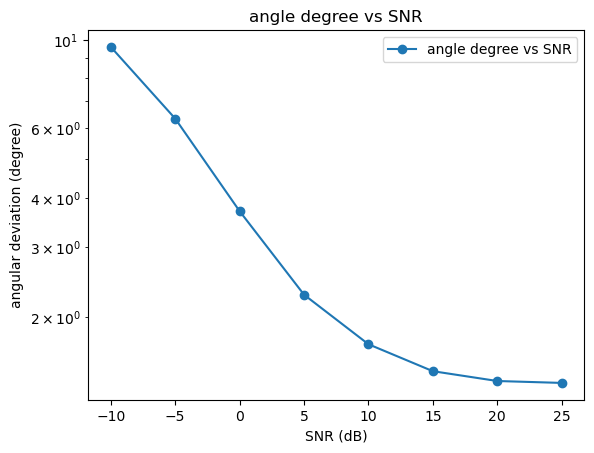

In [11]:

data_snrdBvec = np.load('snrdBvec.npy')
data_performance = np.load('performance_fixed.npy')

print(data_snrdBvec)
print(data_performance)

angle_degree = np.sqrt(data_performance)*180/np.pi

 # Create a figure and axis
fig, ax = plt.subplots()
# Plot data
ax.semilogy(snrdBvec, angle_degree, label='angle degree vs SNR', marker='o')
# Set labels and title
ax.set_xlabel('SNR (dB)')
ax.set_ylabel('angular deviation (degree)')
ax.set_title('angle degree vs SNR')
# Display legend
ax.legend()
# Show the plot
plt.show()

In [8]:
print(np.sqrt(1/(99.0+1.0)))

0.1
